In [229]:
def conversion(path):
    df = pd.read_csv(path, sep=';', dtype=str)
    df = df[df['AT'] != 'AT']
    
    for col in df.columns:
        # On remplace la virgule par un point
        df[col] = df[col].str.replace(',', '.', regex=False)
        # On convertit en float (nombre réel)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna().reset_index(drop=True)
    return df

In [231]:
import pandas as pd
import numpy as np

def summarize_dataset(path=None, group_cols=None):
    df = conversion(path)
    # --- Reste de ta fonction summary ---
    summary = {
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Missing (%)": round(df.isna().mean().mean() * 100, 2)
    }

    diversity_info = {col: df[col].nunique() for col in df.columns}

    freq = None
    if group_cols:
        try:
            freq = df.groupby(group_cols).size().mean()
        except Exception:
            freq = "N/A"

    return {
        "Summary": pd.DataFrame(summary, index=[0]),
        "Column types": df.dtypes,
        "Diversity": pd.Series(diversity_info),
        "Avg group frequency": freq,
        "df_clean": df # Très important pour la suite de ton IA
    }


In [233]:
def clean_nans(df, strategy="drop", fill_value=None):
    
    df_cleaned = df.copy()
    initial_shape = df_cleaned.shape[0]
    
    # 1. Missing analysis
    missing_count = df_cleaned.isna().sum().sum()
    print(f"Missing values found : {missing_count}")
    
    if missing_count == 0:
        return df_cleaned

    # 2. Strategy application
    if strategy == "drop":
        df_cleaned = df_cleaned.dropna()
    elif strategy == "mean":
        df_cleaned = df_cleaned.fillna(df_cleaned.mean(numeric_only=True))
    elif strategy == "median":
        df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))
    elif strategy == "ffill":
        df_cleaned = df_cleaned.fillna(method='ffill')
    
    final_shape = df_cleaned.shape[0]
    print(f"cleaning done. Deleted lines : {initial_shape - final_shape}")
    
    return df_cleaned

In [235]:
def extract_clean_features(df):
    df_feat = df.copy()
    features_pure = ['AT', 'RH'] 
    X = df_feat[features_pure]
    y = df_feat['AP'] 
    return X, y

In [237]:
from sklearn.preprocessing import MinMaxScaler

def normalize_features(df):
    df_scaled = df.copy()
    cols_to_scale = df_scaled.select_dtypes(include=['float64', 'int64', 'int32']).columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])
    
    return df_scaled, scaler

In [239]:
def split_data(X, y, split_ratio=0.8):
    split_index = int(len(X) * split_ratio)

    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test

In [241]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def metrics(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    print(f"📊 Modele Performance :")
    print(f"MAE  (Mean absolute error) : {mae:.4f}")
    print(f"MSE                  : {mse:.4f}")
    print(f"RMSE (Root of the squared error) : {rmse:.4f}")
    print(f"R² Score (Precision) : {r2:.4f} ({r2*100:.2f}%)")

In [243]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title="Real vs Prediction Comparison"):
    plt.figure(figsize=(15, 6))
    
    # On prend un échantillon pour que le graphique soit lisible
    plt.plot(y_true.values[:200], label="Real", color="blue", linewidth=2)
    plt.plot(y_pred[:200], label="Predicted", color="red", linestyle="--", linewidth=2)
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("CNormalized Consumption")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(r'C:\Users\User\Desktop\hachathon\pressure_result.png', dpi=300, bbox_inches='tight')
    plt.show()

In [245]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, color='purple', alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='-')
    plt.title("Errors Destribution (Residues)")
    plt.xlabel("Discrepancy between Actual and Predicted")
    plt.ylabel("Frequency")
    plt.savefig(r'C:\Users\User\Desktop\hachathon\pressure_residual.png', dpi=300, bbox_inches='tight')
    plt.show()

In [247]:
def plot_feature_importance(model, X_train):
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
    plt.title("Quelles variables influencent le plus la prédiction ?")
    plt.xlabel("Niveau d'importance")
    plt.show()

In [249]:
def plot_lr_weights(model, X_train):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Pour la Régression Linéaire, on utilise .coef_ au lieu de .feature_importances_
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Weight': model.coef_
    })
    
    # On ajoute une colonne pour l'importance absolue (la force de l'influence)
    importance['Absolute_Weight'] = np.abs(importance['Weight'])
    importance = importance.sort_values(by='Absolute_Weight', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Weight'], color='orange')
    plt.title("Coefficients de la Régression Linéaire")
    plt.xlabel("Valeur du Coefficient (Poids)")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [251]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, i, name):
    plt.figure(figsize=(15, 10))
    cor = df.corr()
    sns.heatmap(cor, annot=False, cmap='coolwarm', center=0)
    plt.title(f"Correlation Matrix - {name}")
    plt.savefig(f"{i}_{name}_correlation.png", dpi=300, bbox_inches='tight')
    plt.show()

In [253]:
def filter_high_correlation(df, threshold=0.9):
    # 1. Calculer la matrice de corrélation en valeur absolue
    corr_matrix = df.corr().abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns 
               if any(upper[column] > threshold) 
               and column not in ['target_future', 'Global_Power']]
    
    print(f"Variables supprimées (car trop corrélées) : {to_drop}")
    
    # 4. Créer le nouveau DataFrame allégé
    df_reduced = df.drop(columns=to_drop)
    return df_reduced

In [255]:
path = r'C:\Users\User\Desktop\hachathon\pressure.csv'
df = pd.read_csv(path, sep=None, engine='python', na_values=['?', 'n/a', 'null', ' ', '-', 'N/A'])

In [257]:
summarize_dataset(path, None)

{'Summary':     Rows  Columns  Missing (%)
 0  47840        5          0.0,
 'Column types': AT    float64
 V     float64
 AP    float64
 RH    float64
 PE    float64
 dtype: object,
 'Diversity': AT    2773
 V      634
 AP    2517
 RH    4546
 PE    4836
 dtype: int64,
 'Avg group frequency': None,
 'df_clean':           AT      V       AP     RH      PE
 0      14.96  41.76  1024.07  73.17  463.26
 1      25.18  62.96  1020.04  59.08  444.37
 2       5.11  39.40  1012.16  92.14  488.56
 3      20.86  57.32  1010.24  76.64  446.48
 4      10.82  37.50  1009.23  96.62  473.90
 ...      ...    ...      ...    ...     ...
 47835  15.12  48.92  1011.80  72.93  462.59
 47836  33.41  77.95  1010.30  59.72  432.90
 47837  15.99  43.34  1014.20  78.66  465.96
 47838  17.65  59.87  1018.58  94.65  450.93
 47839  23.68  51.30  1011.86  71.24  451.67
 
 [47840 rows x 5 columns]}

In [259]:
df = conversion(path)
df_propre = clean_nans(df)

Missing values found : 0


In [261]:
from sklearn.preprocessing import MinMaxScaler

X_raw, y_raw = extract_clean_features(df_propre)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler_X.fit_transform(X_raw), columns=X_raw.columns)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = pd.Series(scaler_y.fit_transform(y_raw.values.reshape(-1, 1)).flatten())

In [263]:
X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled)

print(f"Prêt pour l'entraînement !")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")

Prêt pour l'entraînement !
X_train : (38272, 2), y_train : (38272,)


<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\User\AppData\Local\Temp\ipykernel_21196\3398960722.py:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif name is "Bayesian Ridge":



==================== LinearRegression ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0944
MSE                  : 0.0151
RMSE (Root of the squared error) : 0.1228
R² Score (Precision) : 0.3014 (30.14%)


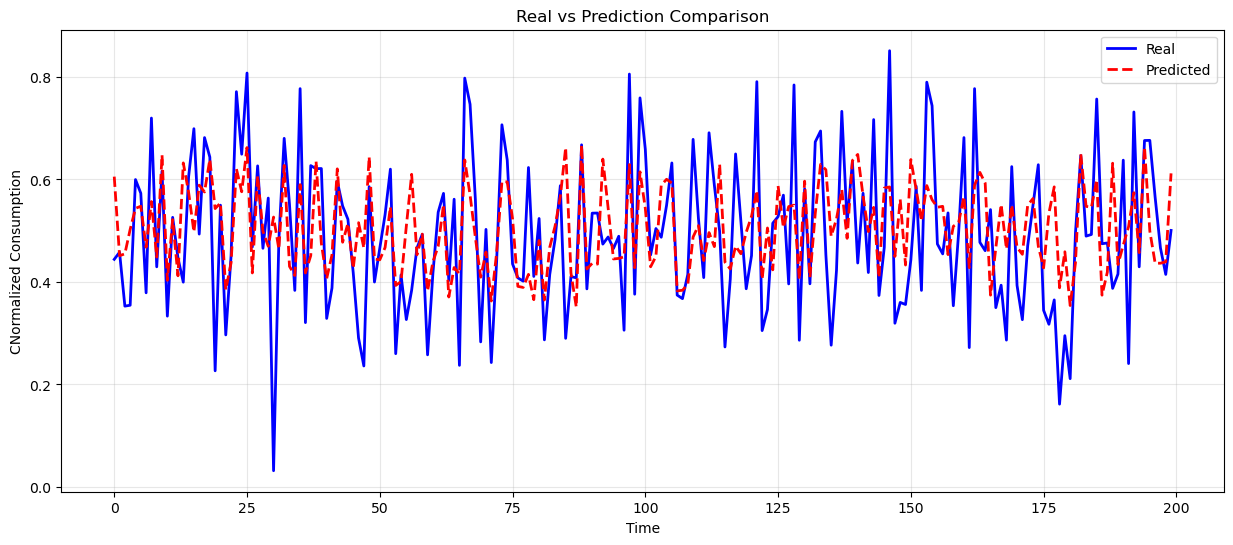

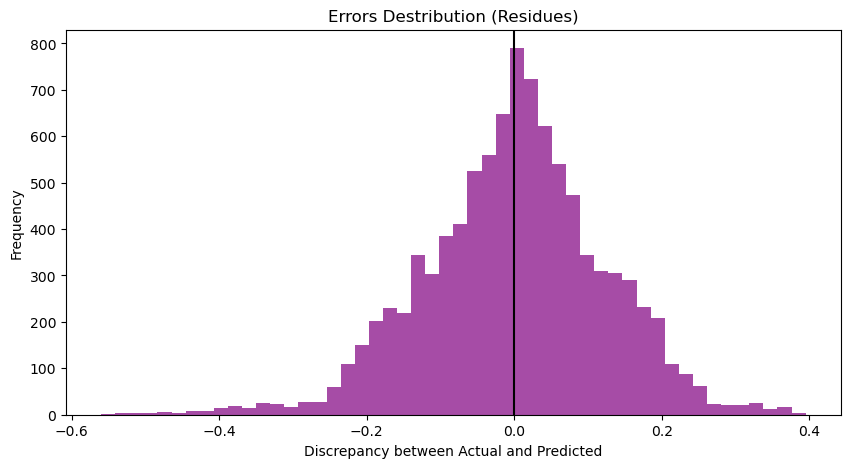

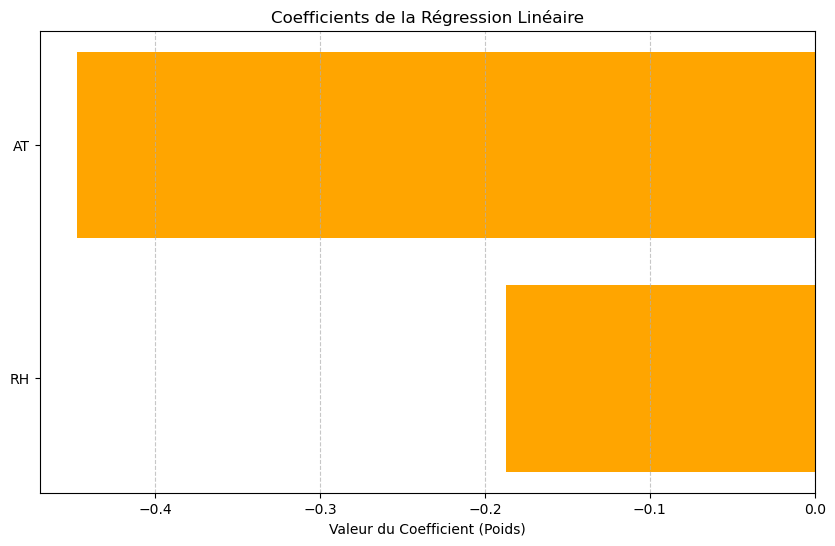


==================== Ridge (Linaire +) ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0944
MSE                  : 0.0151
RMSE (Root of the squared error) : 0.1228
R² Score (Precision) : 0.3014 (30.14%)


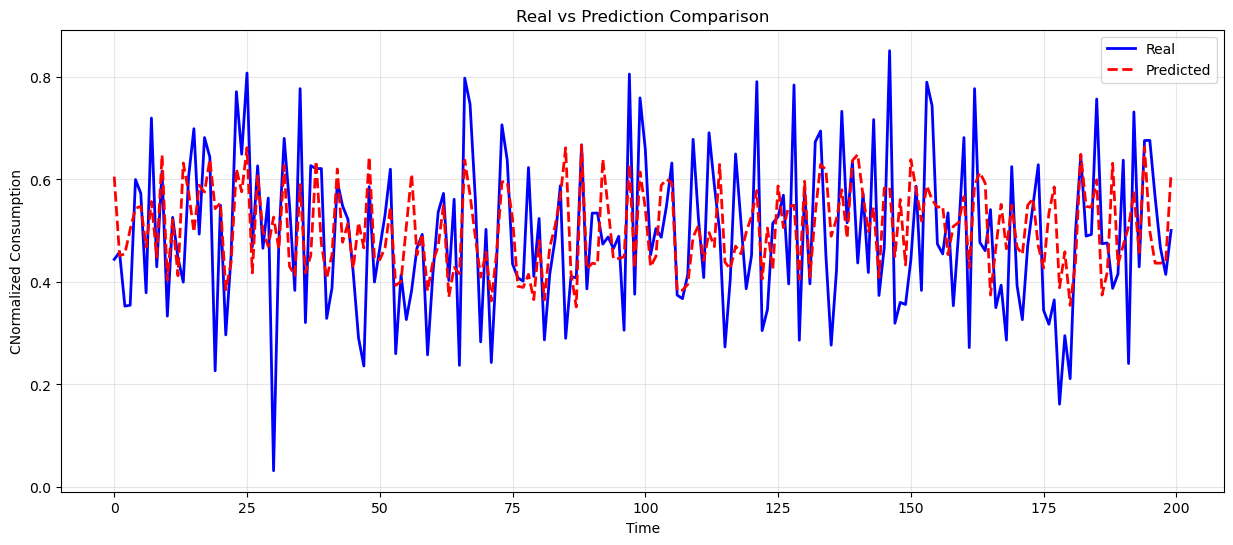

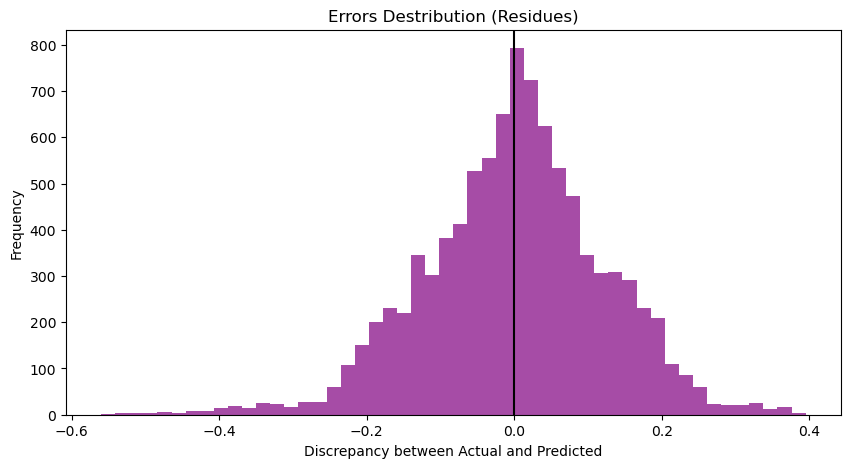

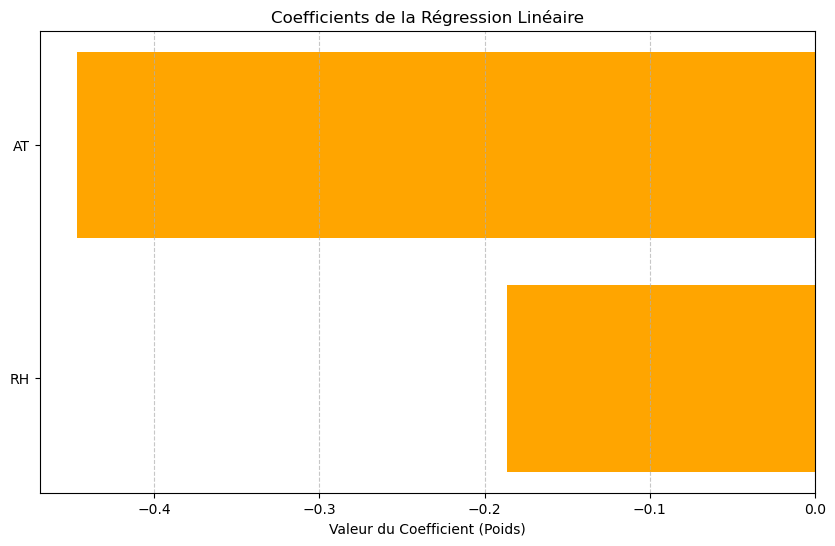


==================== Random Forest ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0754
MSE                  : 0.0095
RMSE (Root of the squared error) : 0.0974
R² Score (Precision) : 0.5610 (56.10%)


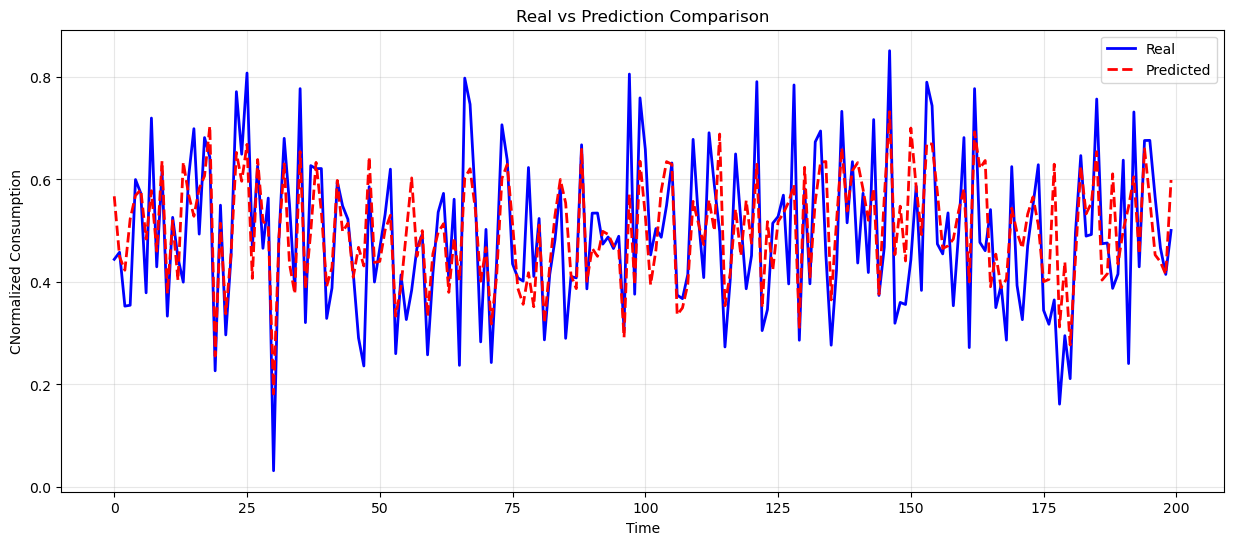

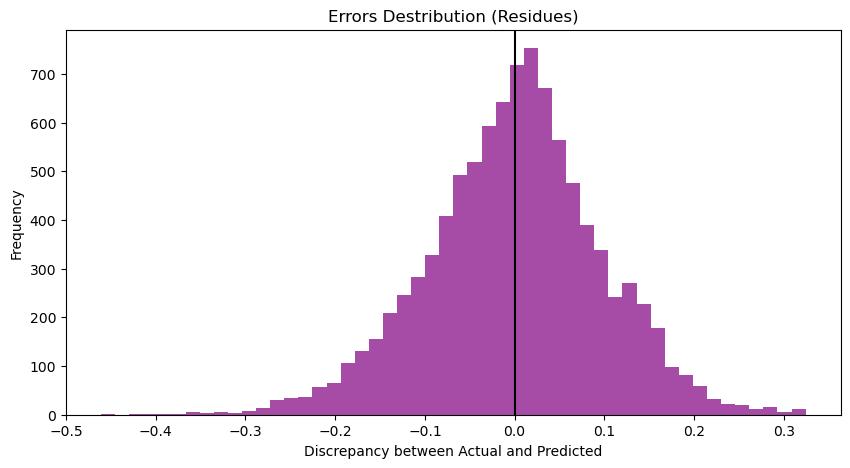

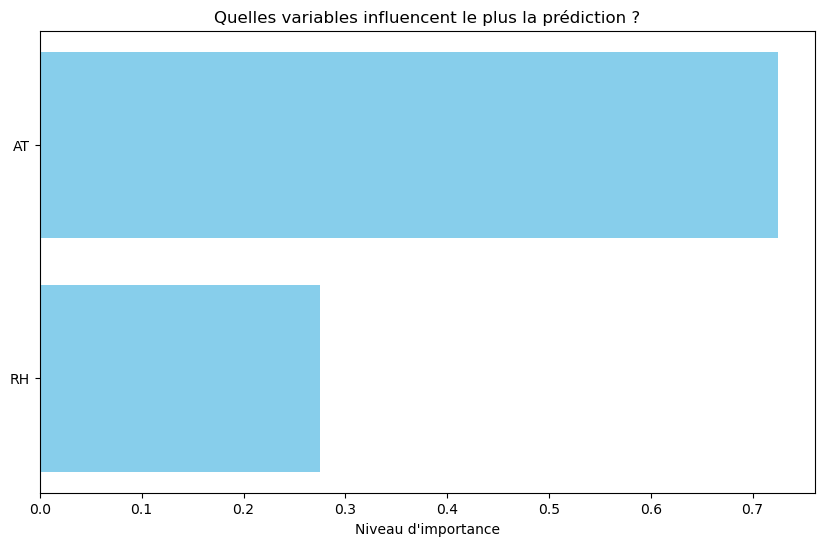


==================== XGBoost ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0856
MSE                  : 0.0121
RMSE (Root of the squared error) : 0.1102
R² Score (Precision) : 0.4381 (43.81%)


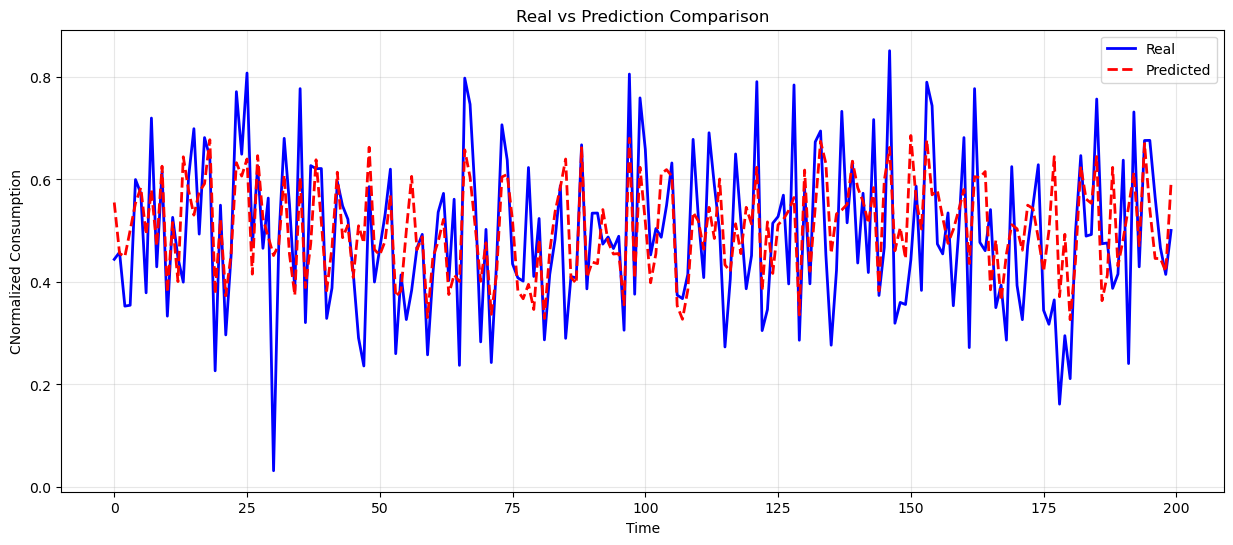

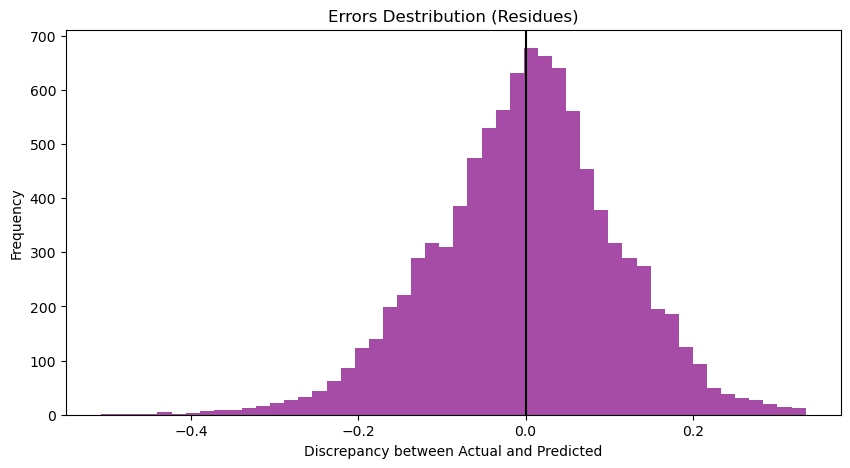

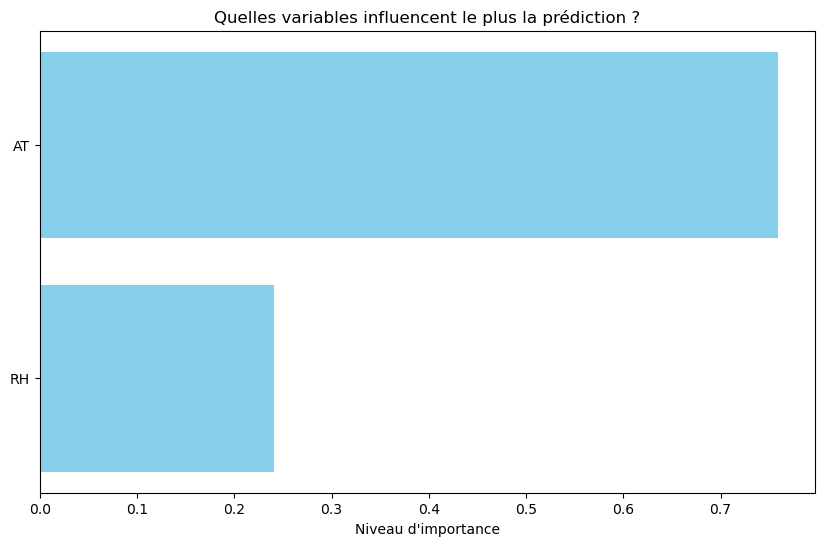


==================== LightGBM ====================
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 38272, number of used features: 2
[LightGBM] [Info] Start training from score 0.504060
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0840
MSE                  : 0.0117
RMSE (Root of the squared error) : 0.1080
R² Score (Precision) : 0.4600 (46.00%)


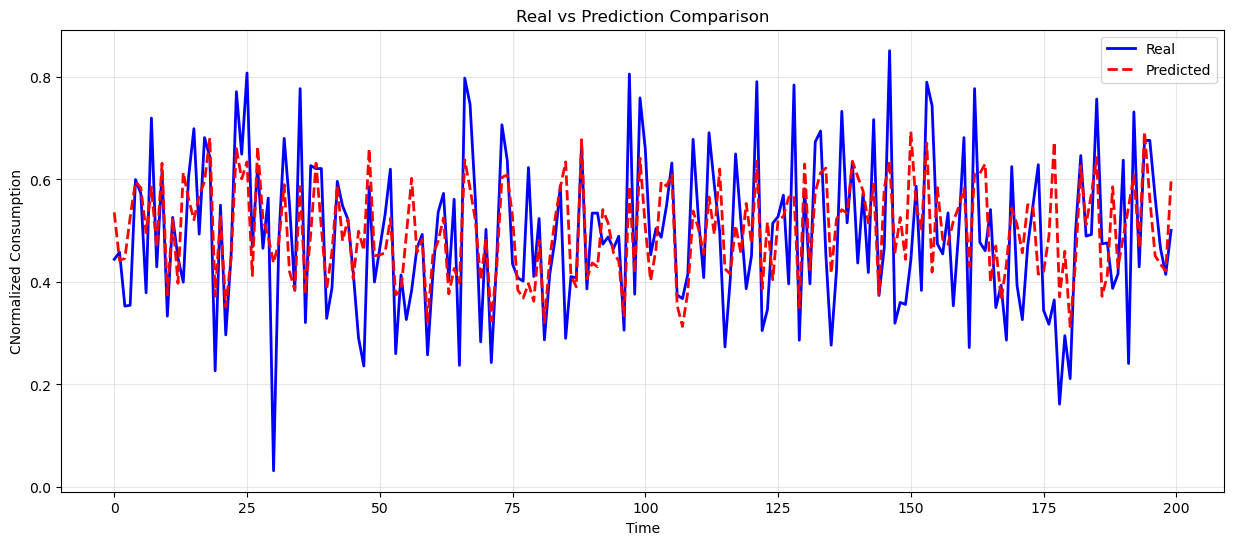

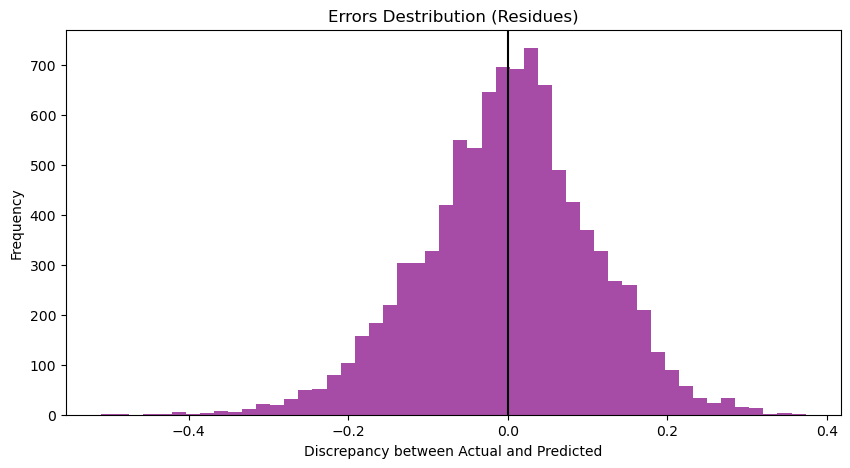

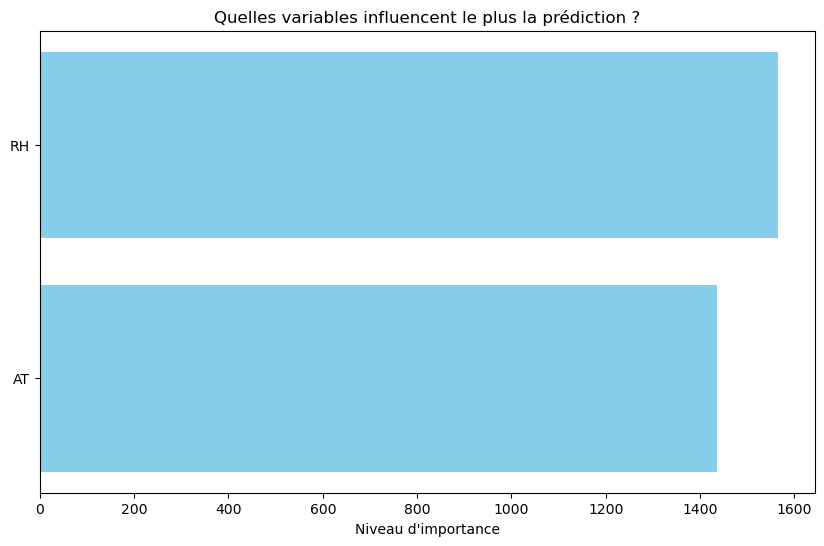


==================== CatBoost ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0839
MSE                  : 0.0115
RMSE (Root of the squared error) : 0.1074
R² Score (Precision) : 0.4657 (46.57%)


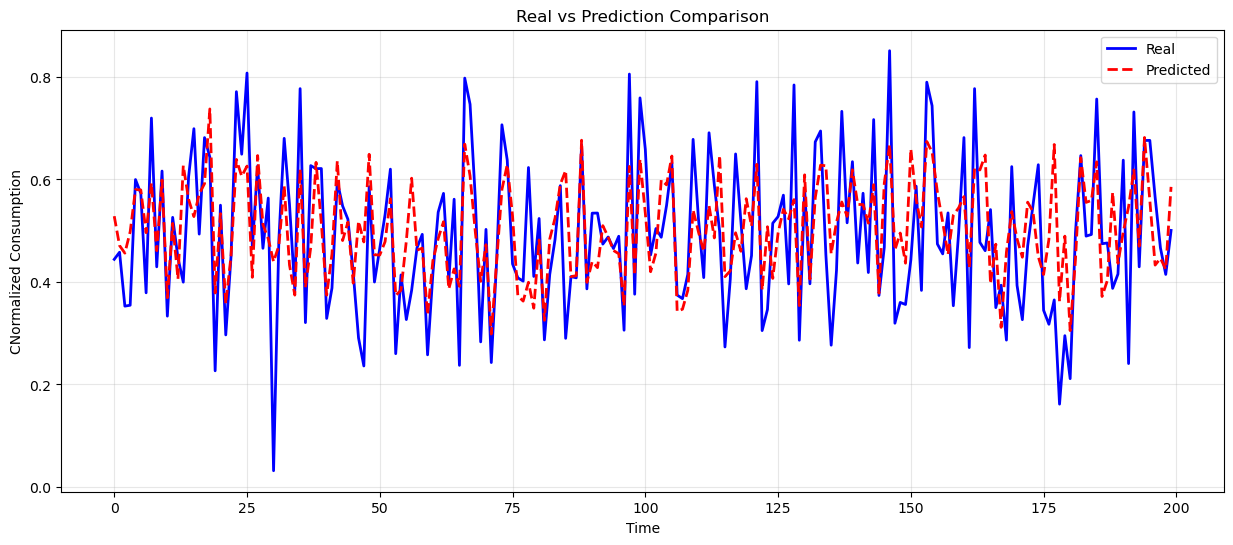

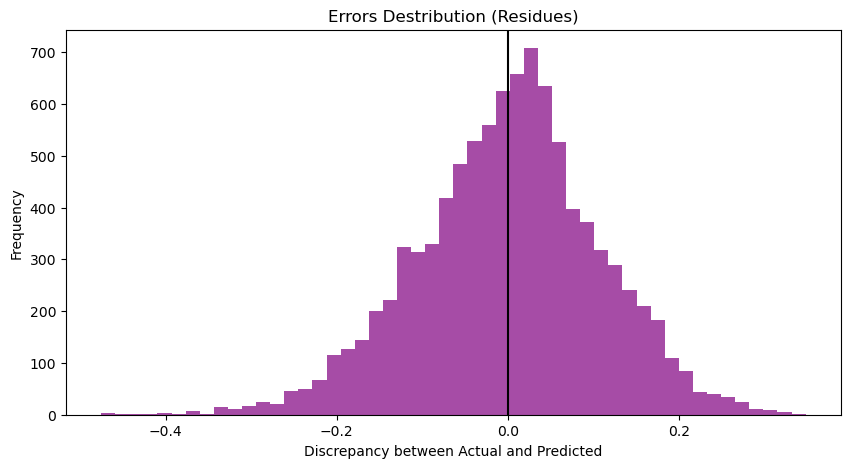

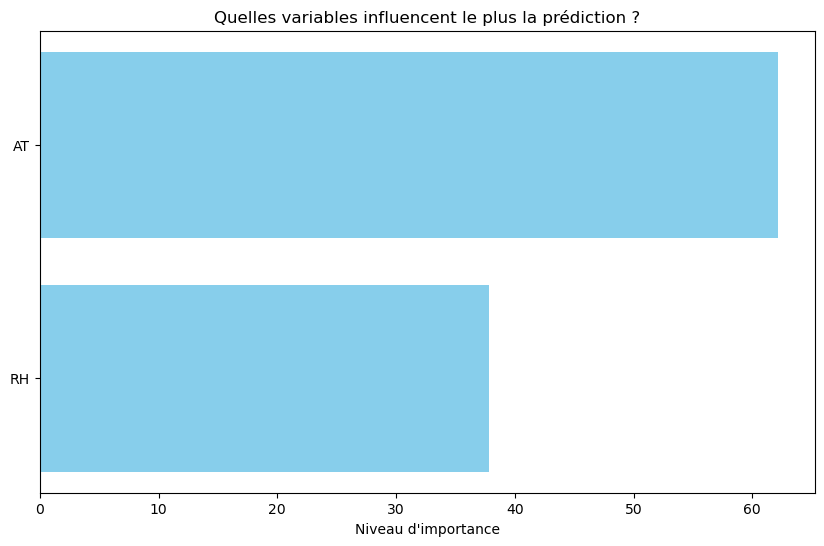


==================== k-NN ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0000
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0013
R² Score (Precision) : 0.9999 (99.99%)


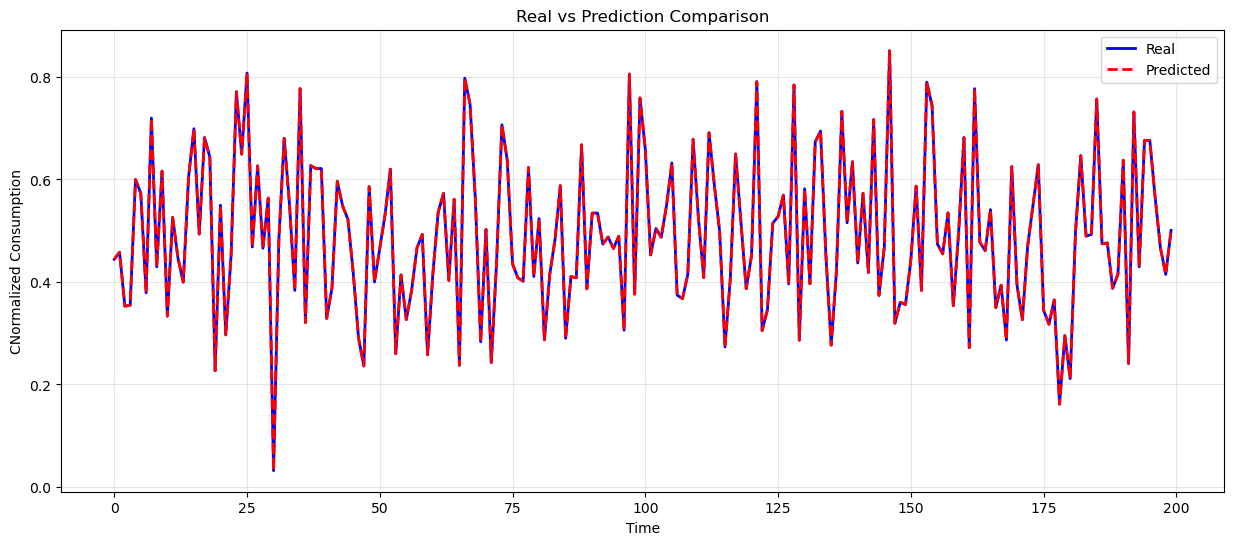

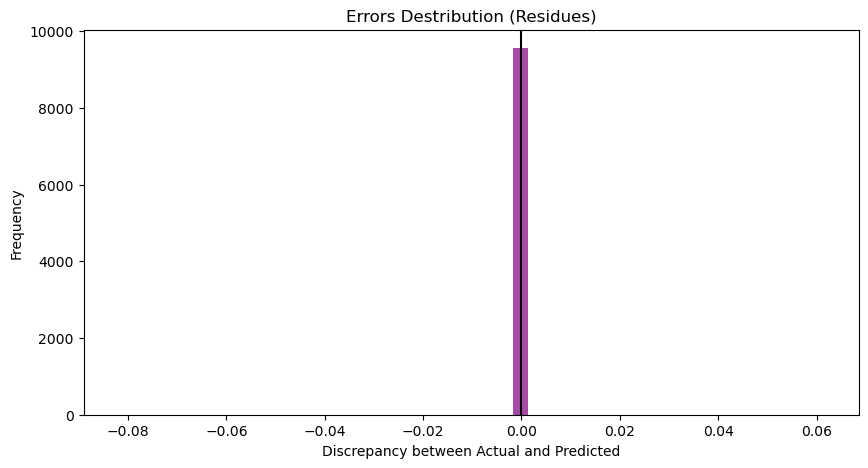

INFO : Variables importances doesn't exist for k-NN.

==================== SVR ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0925
MSE                  : 0.0143
RMSE (Root of the squared error) : 0.1195
R² Score (Precision) : 0.3393 (33.93%)


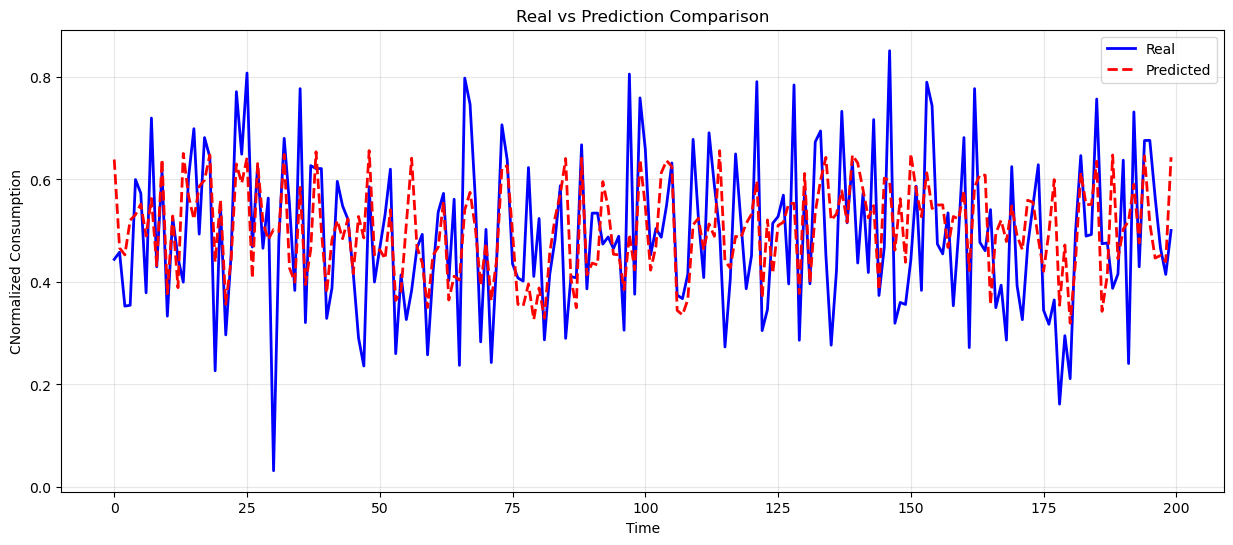

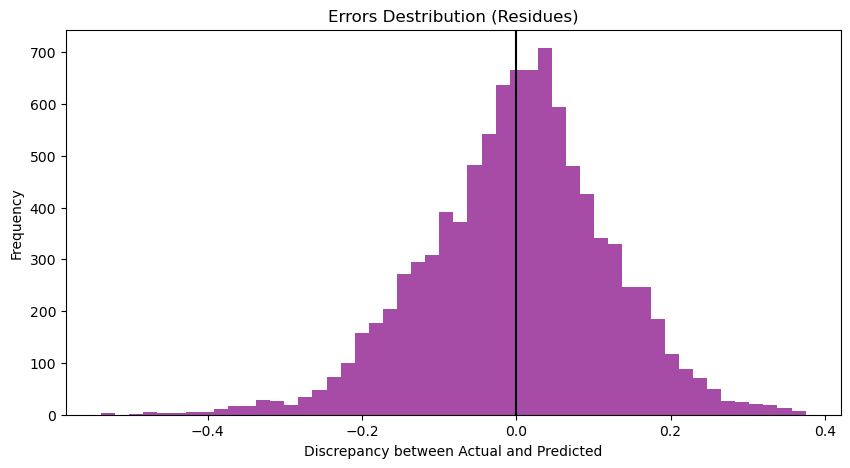

INFO : Variables importances doesn't exist for SVR.

==================== Voting Regressor ====================
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 38272, number of used features: 2
[LightGBM] [Info] Start training from score 0.504060
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0782
MSE                  : 0.0100
RMSE (Root of the squared error) : 0.1001
R² Score (Precision) : 0.5362 (53.62%)


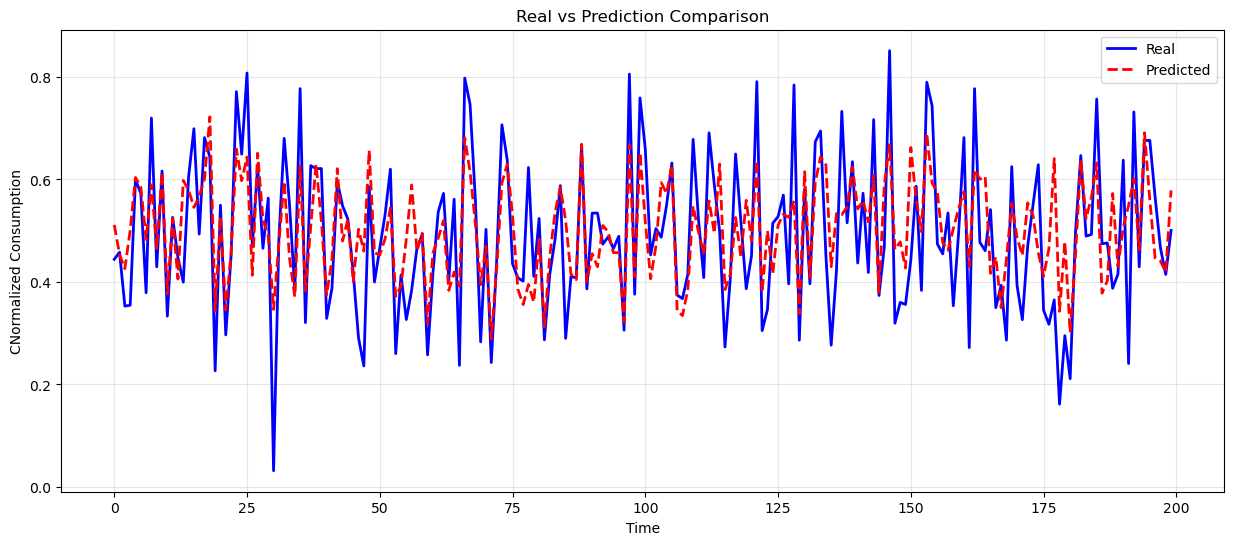

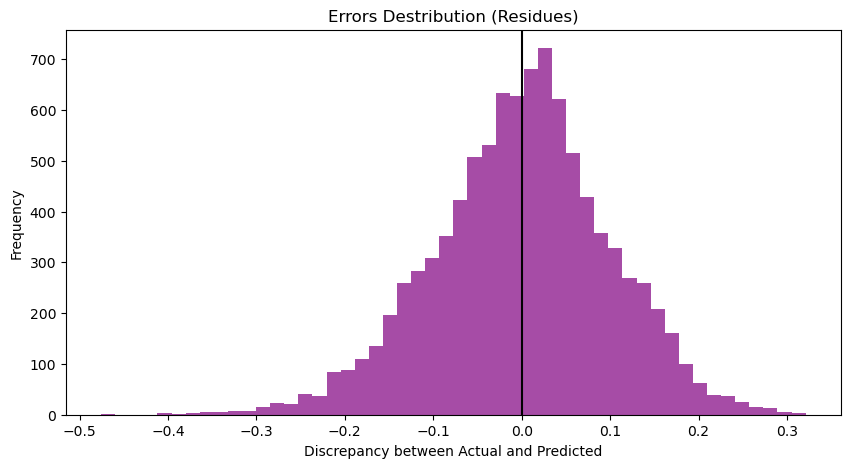

INFO : Variables importances doesn't exist for Voting Regressor.

==================== Stacking Regressor ====================
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 38272, number of used features: 2
[LightGBM] [Info] Start training from score 0.504060
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 30617, number of used features: 2
[LightGBM] [Info] Start training from score 0.503920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51

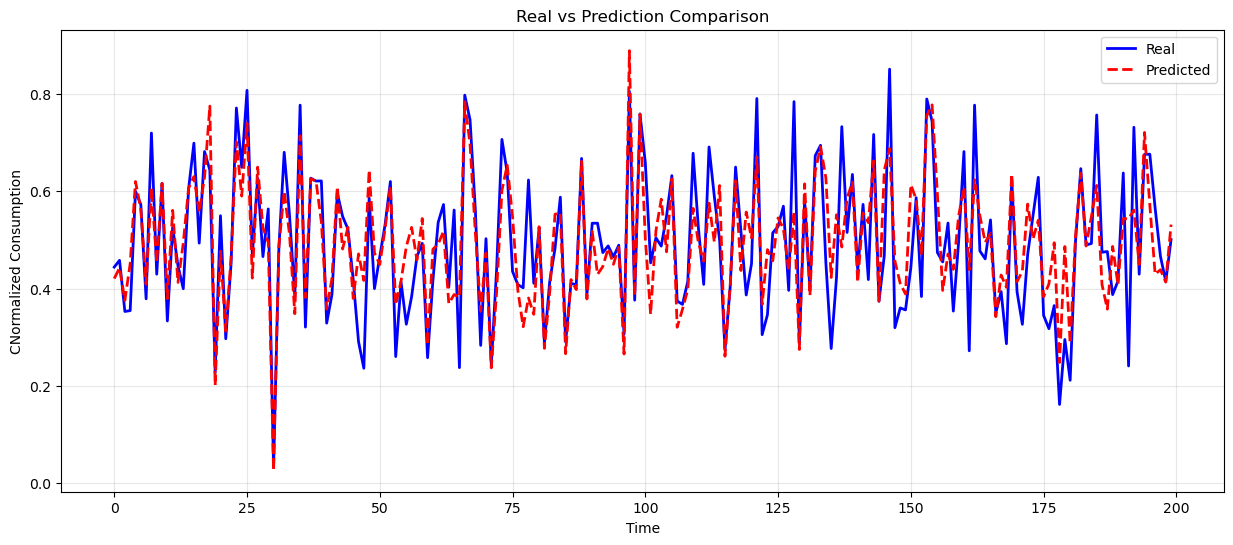

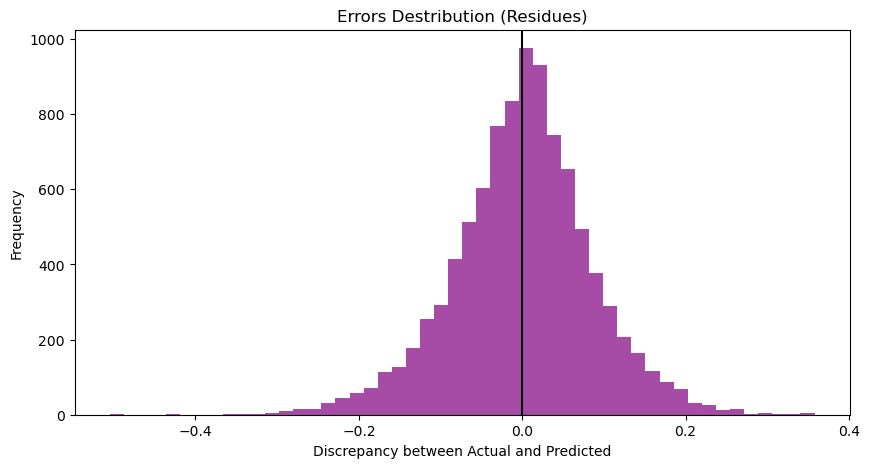

INFO : Variables importances doesn't exist for Stacking Regressor.

==================== HistGradientBoosting ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0840
MSE                  : 0.0116
RMSE (Root of the squared error) : 0.1079
R² Score (Precision) : 0.4608 (46.08%)


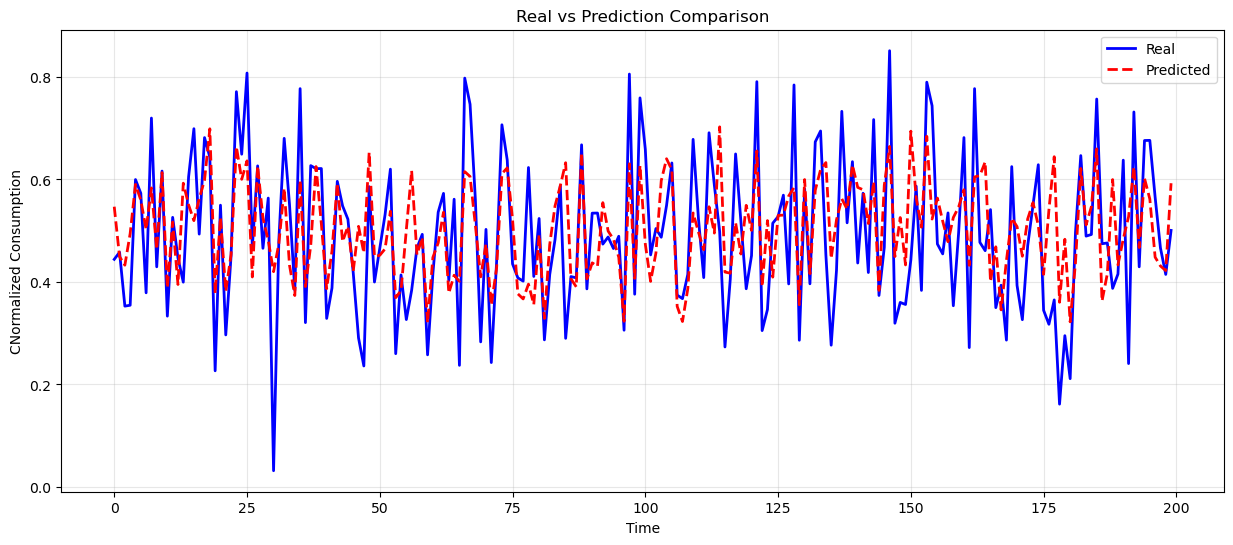

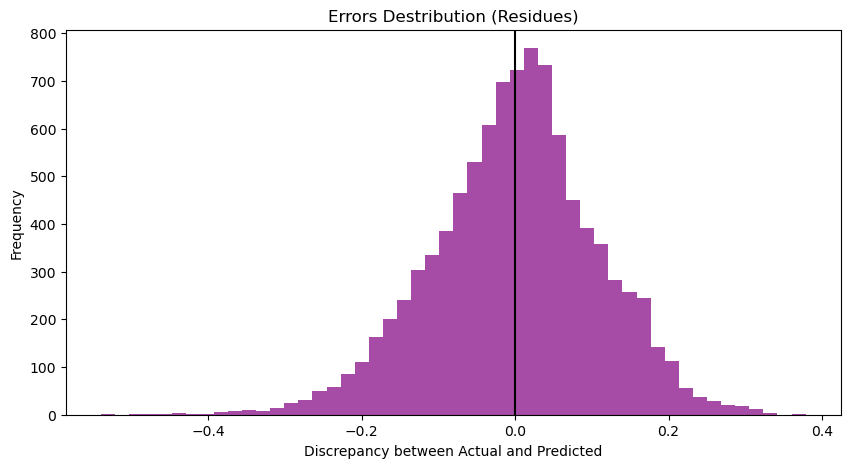

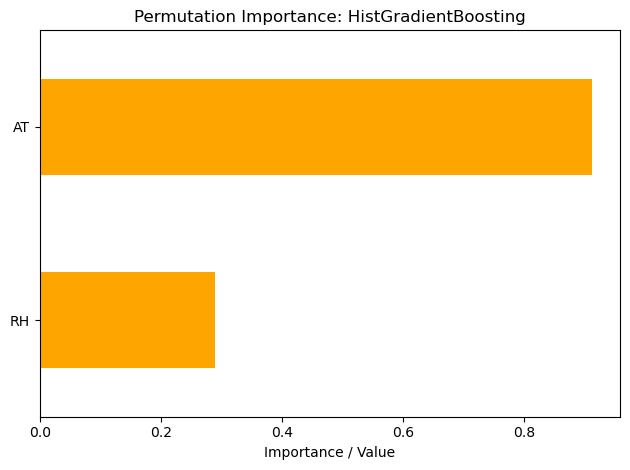


==================== Extra Trees ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0000
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0013
R² Score (Precision) : 0.9999 (99.99%)


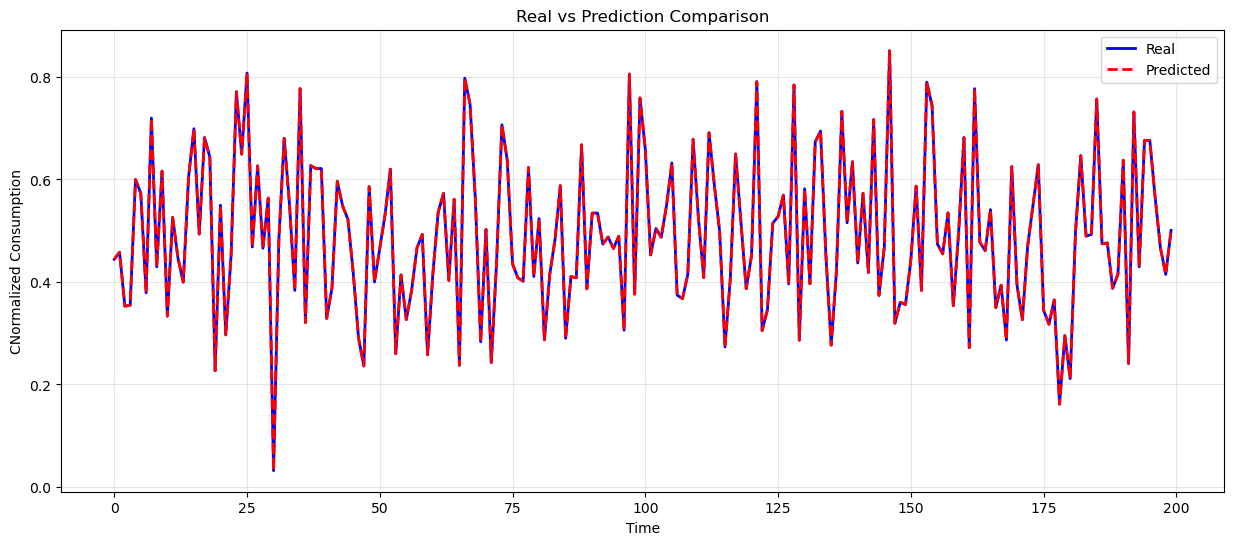

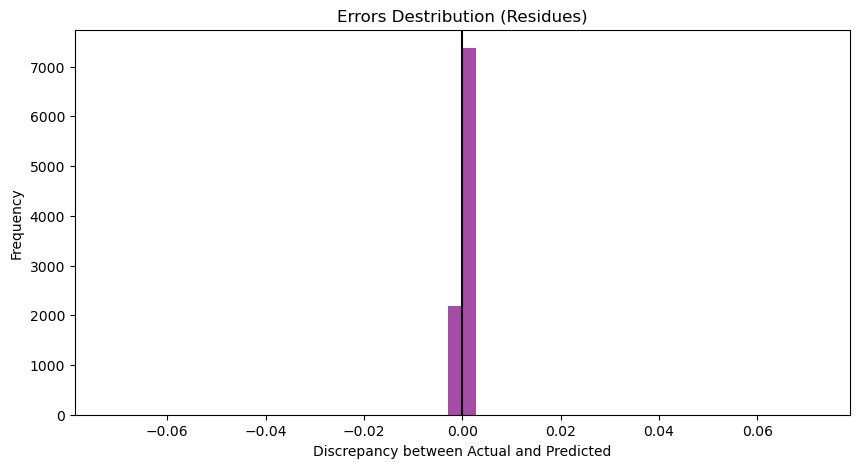

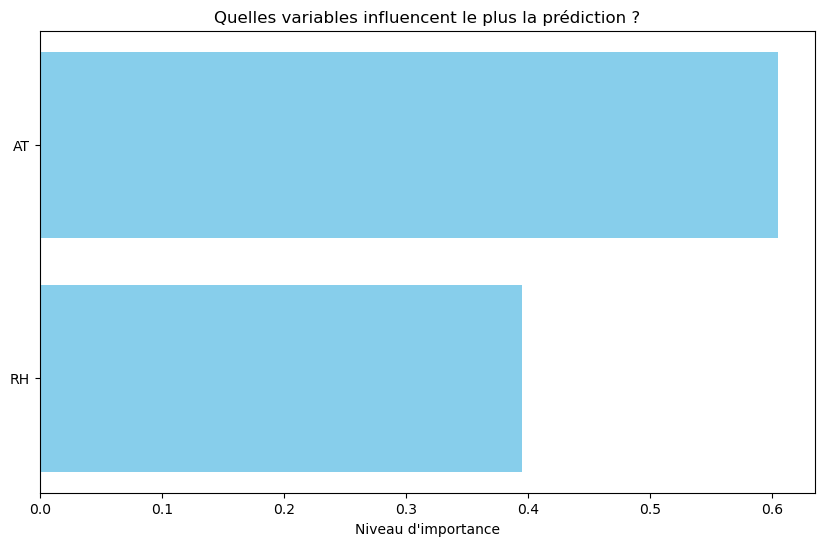


==================== Bayesian Ridge ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0944
MSE                  : 0.0151
RMSE (Root of the squared error) : 0.1228
R² Score (Precision) : 0.3014 (30.14%)


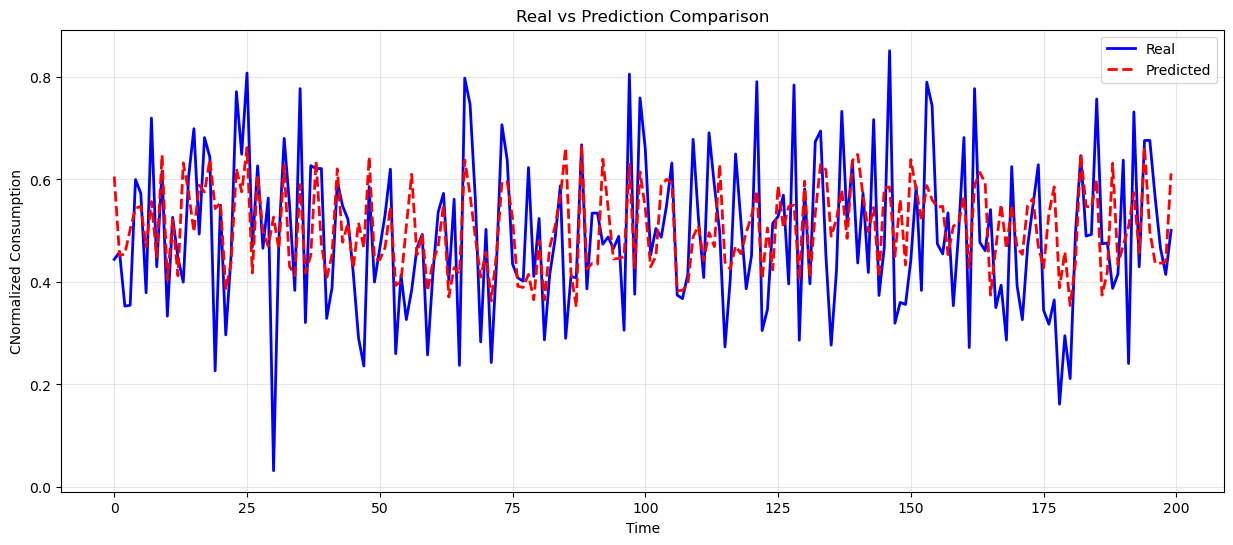

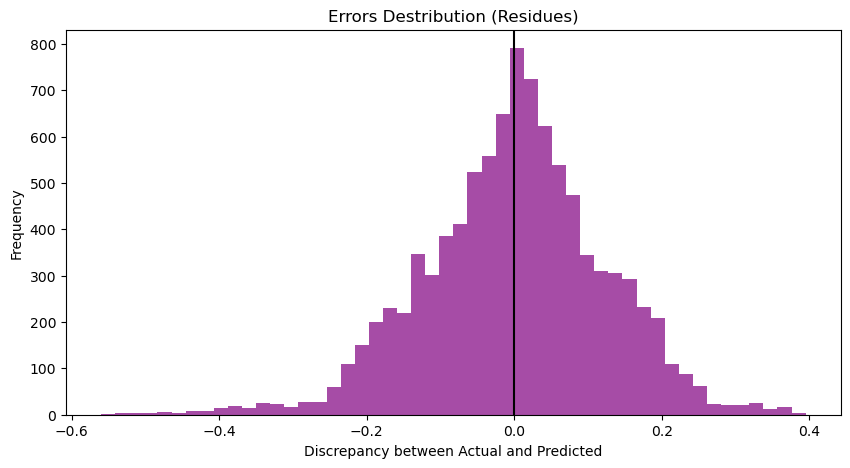

INFO : Variables importances doesn't exist for Bayesian Ridge.


In [265]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge, TweedieRegressor
from sklearn.inspection import permutation_importance

base_estimators = [
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, verbose=0, random_seed=42))
]

models = {
    "LinearRegression": LinearRegression(),
    "Ridge (Linaire +)": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_seed=42),
    "k-NN": KNeighborsRegressor(n_neighbors=7, weights='distance'),
    "SVR": SVR(kernel='rbf', C=1.0),
    "Voting Regressor": VotingRegressor(estimators=base_estimators),
    "Stacking Regressor": StackingRegressor(estimators=base_estimators, final_estimator=Ridge()),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100),    
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
    "Bayesian Ridge": BayesianRidge()
}


results = {}

for name, model in models.items():
    print(f'\n' + '='*20 + f' {name} ' + '='*20)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics & Basics Graphics 
    metrics(y_test, preds)
    plot_predictions(y_test, preds)
    plot_residuals(y_test, preds)
    
    if name in ["LinearRegression", "Ridge (Linaire +)"]:
        plot_lr_weights(model, X_train)
        
    elif hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, X_train)
        
    elif name == "CatBoost":
        plot_feature_importance(model, X_train)

    elif name is "Bayesian Ridge":
        weights = pd.Series(model.coef_, index=X_train.columns).sort_values()
        weights.plot(kind='barh', color='skyblue')
        plt.title(f"Coefficients (Variables Weight) : {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
        
    elif name == "HistGradientBoosting":
        result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
        importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values()
        importances.plot(kind='barh', color='orange')
        plt.title(f"Permutation Importance: {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"INFO : Variables importances doesn't exist for {name}.")

📊 Modele Performance :
MAE  (Mean absolute error) : 0.0000
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0013
R² Score (Precision) : 0.9999 (99.99%)


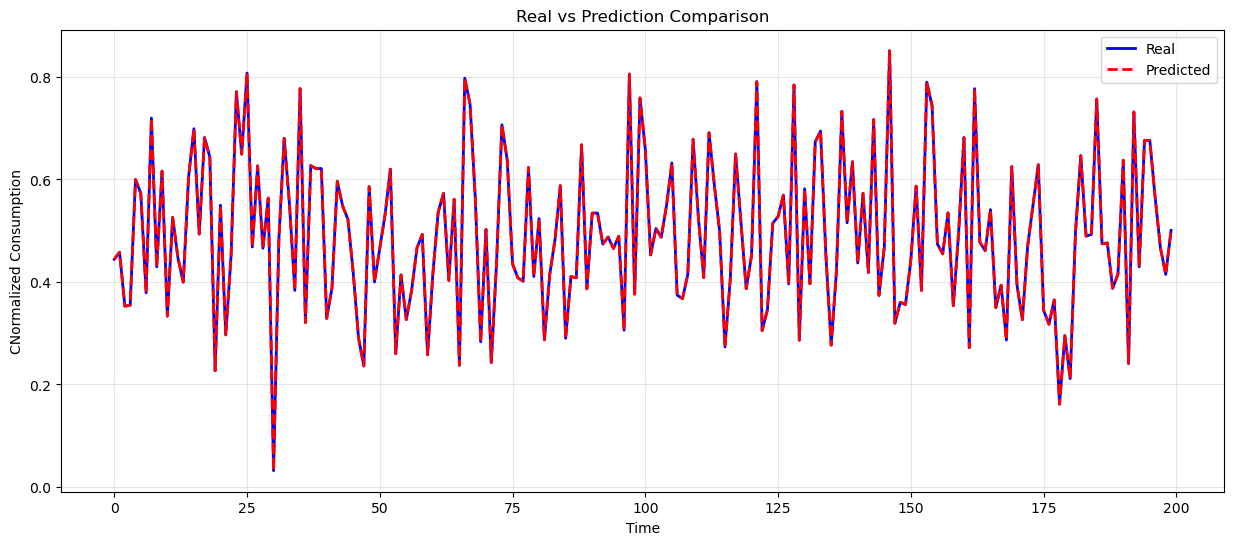

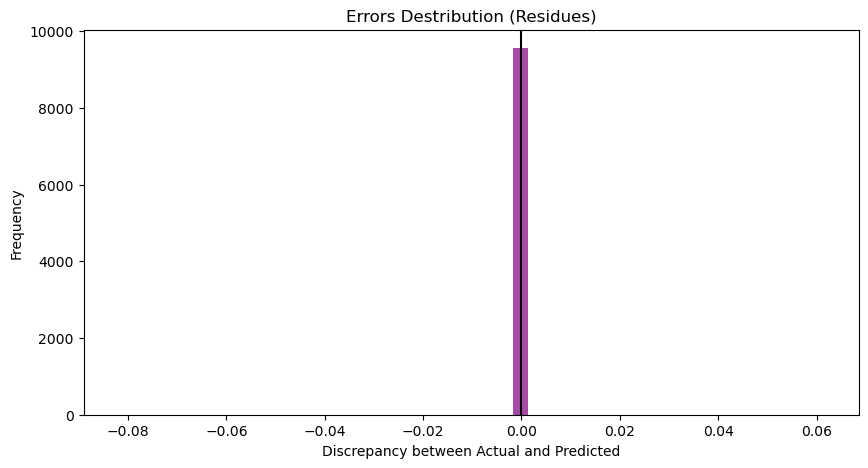

In [267]:
from sklearn.neighbors import KNeighborsRegressor 

model = KNeighborsRegressor(n_neighbors=7, weights='distance')
model.fit(X_train, y_train)
preds = model.predict(X_test)

metrics(y_test, preds)
plot_predictions(y_test, preds)
plot_residuals(y_test, preds)